# Генетичен Алгоритъм

Генетичните алгоритми са клас адаптивни алгоритми за стохастична оптимизация, които включват търсене и итеративно оптимизиране на решението.

Генетичен алгоритъм е евристика за търсене, която е вдъхновена от теорията на Чарлз Дарвин за естествената еволюция. Този алгоритъм отразява процеса на естествения подбор, където най-силните индивиди са избрани за възпроизвеждане, за да произвеждат потомство на следващото поколение.


Понятието за естествена селекция може да се приложи за проблем при търсене. Разглеждаме набор от решения за даден проблем и избираме набор от най-добрите от тях.

Примерът който съм дал е за проблема с пътуващия търговец(Traveling Salesman Problem(TSP)). Въпроса който задава е "Като се има предвид списък на градовете и разстоянията между всяка двойка, кой е най-краткият възможен маршрут, който посещава всеки град и се връща към града на произхода?"



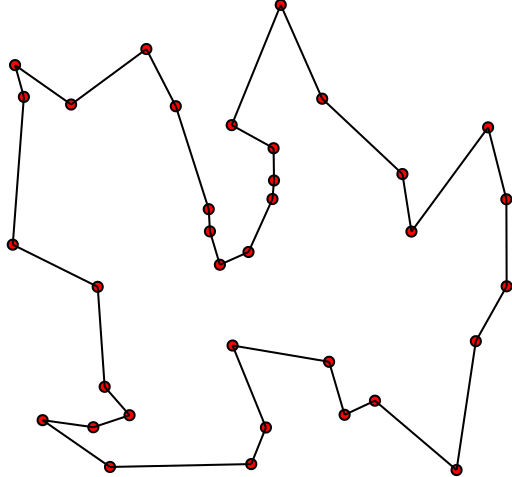
Илюстрация на потенциално решение за TSP (By Xypron [Public domain], from Wikimedia Commons)


Нека видим няколко дефиниции за генетичния алгоритъм, които са адаптирани за TSP.

    •Gene(Ген): Отговаря на City (представен като (x, y) координати).
 
    •Individual(or Chromosome): Един път, отговарящ на горепосочените условия.
 
    •Population: Колекция от възможни маршрути (т.е. събиране на индивиди).
 
    •Parent: Два маршрута, които се комбинират, за да се създаде нов маршрут.
 
    •Mating Pool: Колекция от родители, които се използват за създаване на следващото ни население (като по този начин се създава следващото поколение маршрути)
     
    •Fitness: Функция, която ни казва колко е добър всеки маршрут (в нашия случай, колко кратко е разстоянието).
 
    •Mutation: Начин за въвеждане на вариации в нашето население чрез случайна смяна на два града по маршрут.
 
    •Elitism: Начин за пренасяне на най-добрите индивид в следващото поколение.

In [1]:
# Пакети за анализ на данните
import numpy as np, random, operator, pandas as pd
# Пакети за визуализация
import matplotlib.pyplot as plt
# Позволява на графиките да се показват под кода
%matplotlib inline

# Създаваме необходимите класове и функции

In [2]:
# Първо създаваме City class това ще ни позволи да създадем 
# и управляваме нашите градове. Това са просто нашите (x, y) координати.
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    #Добавяме изчисление на distance като използваме Питагоровата теорема.
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    #__repr__ е по-чист начин за извеждане на градовете като координати.
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [3]:
#Създаване и дефиниране на class Fitness, който ще третираме като обратното на разточнието от маршрута.
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

# Създаваме нашето първоначално население

In [4]:
#Генериране на маршрут, като произволно избираме реда,в който посещаваме всеки град.
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
#Създаване на популация(лист от маршрути), като правим цикъл чрез createRoute докато стигнем изисквания брои маршрути.
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

# Създаваме генетичния алгоритъм

In [6]:
#Като използваме Fitness, ще класираме всеки индивид от нашата популация.
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Има няколко варианта как да изберете родителите, които ще се използват за създаване на следващото поколение. Най-често срещаните подходи са или пропорционалната селекция на фитнес (известна като "избор на рулетка") или избор на турнир.

Начинът който ще използван е ориоирцуибакбата селекция на фитнес, кадето fitness на всеки индивид спрямо населението се използва за определяне на вероятност за селекция.

Друга особеност, която трябва да се обмисли, е използването на elitisism. С elitism, най-добре представящите се лица от населението автоматично ще се прехвърлят към следващото поколение, като гарантират, че най-успешните индивиди продължават.

In [7]:
#Създаваме функция за избор, която ще се използва за създаване на списък с родителски маршрути.
def selection(popRanked, eliteSize):
    selectionResults = []
    #Създаваме колелото на рулетката, като изчисляваме относителната fitness тежест за всеки индивид
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    #Тук вкарваме Elitism за да запазим нашите наи-добри маршрути.
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    #Сравняваме произволно изтеглени числа с тези fitness тегла, за да изберем нашия басейн за чифтосване
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#В крайна сметка функцията Selection връща списък с идентификатори на маршрути.

In [8]:
#Следкато имаме лист с идентификатори на маршрути, просто ги изваждаме от нашата популация.
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

# Кръстосване
Кръстосване (на английски: crossover) е термин в областта на генетичните алгоритми, с който се означава един от трите вида генетични оператори, използвани в процеса на търсене на решение на дадена оптимизационна задача. Операторът отговаря за модифицирането по определени правила на едно или повече кандидат-решения („хромозоми“) от едно поколение на популацията в следващото поколение.

Съществуват много техники на кръстосване, вдъхновени от различни биологични видове.

Кръстосване в единична точка
„Хромозомите“ на двете родителски решения се представят във вид на низове (числови, символни и др.) Избира се само една точка на кръстосване по схемата по-долу:

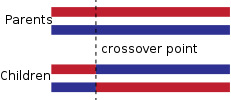

Кръстосване в две точки
При този вариант трябва да се изберат две точки на кръстосване. Отново се получават две решения-деца, като, редувайки се, се взимат сегменти ту от единия, ту от втория родител.

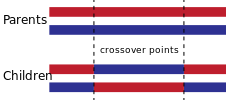

Но, TSP е уникален с това, че трябва да включим всички места точно веднъж. За да спазваме това правило, можем да използваме специална развъдна функция, наречена подредено кръстосване. В подредено кръстосване ние произволно избираме подмножество от първия родителски низ и след това попълваме остатъка от маршрута с гените от втория родител в реда, в който те се появяват, без да дублират гени в избраното подмножество от първия родител.

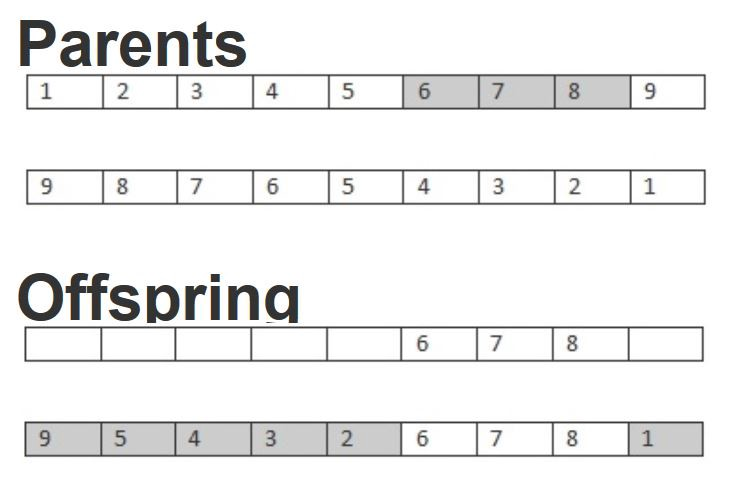

In [9]:
#Създаваме функция на кръстосване за двама родители, за да създадат едно дете.
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [10]:
#Създаваме функция на кръстосване върху целия чифтосващ басейн.
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

# Мутация
Мутация (mutation) в областта на генетичните алгоритми е термин, с който се означава генетичен оператор, използван за поддържане на генетичното разнообразие от едно поколение на популацията на генетичен алгоритъм до следващото. 

Мутацията изпълнява важна функция в GA, тъй като помага да се избегне локалната конвергенция чрез въвеждане на нови маршрути, които ще ни позволят да изследваме други части от пространството на решението.

# Видове мутации

За всички видове мутации по-долу, нека е дадена начална хромозома във вида:
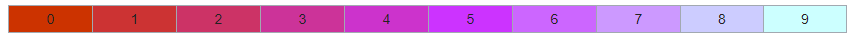
1. Суап или „размяна на местата“ (swap)
Нека бъдат избрани на случаен принцип два бита от двоичния низ на хромозомата:

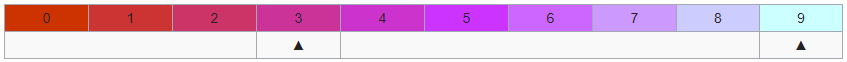

След прилагане на мутация от вид суап, двата бита си разменят местата и хромозомата добива новия вид:

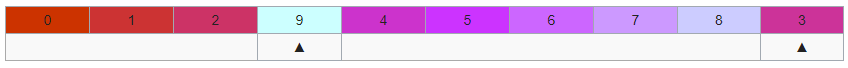

2. Инверсия (inversion)

Нека бъдат избрани на случаен принцип два бита от двоичния низ на хромозомата:

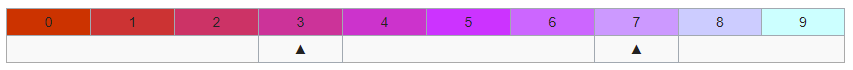

След прилагане на мутация от вид инверсия, низът между двата бита се обръща и хромозомата добива новия вид:

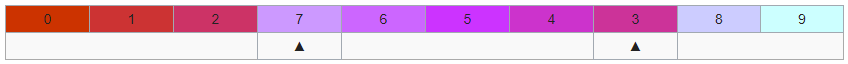

3. Вмъкване (insert)

Нека бъдат избрани на случаен принцип два бита от двоичния низ на хромозомата:

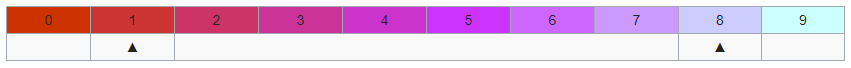

След прилагане на мутация от вид вмъкване, вторият бит се залепва за първия, измествайки с един останалите битове в хромозомата. Хромозомата добива новия вид:

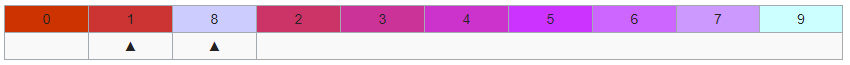

4. Разбъркване (scramble)

Нека бъдат избрани на случаен принцип два бита от двоичния низ на хромозомата:

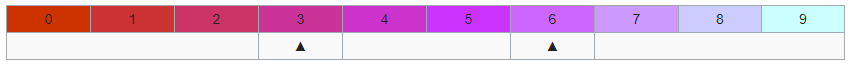

При мутацията от вид разбъркване битовете в подниза, образуван от двата случайно избрани бита (включително и тях), се 
разбъркват. Хромозомата добива новия вид:

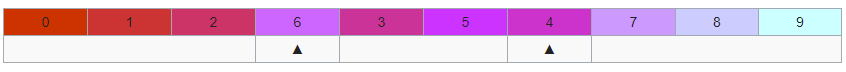


Tъй като трябва да спазваме нашите правила, не можем да изпуснем градовете. Ще използваме мутация на суап. Това означава, че с определена ниска вероятност два града ще разменят местата в нашия маршрут. Ще направим това за един човек в нашата mutate функция:

In [11]:
#Създаваме функция за мутиране на един маршрут.
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [12]:
#Създаваме функция за мутиране на цяла популация.
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [13]:
#Слагаме всички стъпки заедно, за да създадем следващото поколение
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Най-накрая имаме всички парчета, за да създадем нашия GA! Всичко, което трябва да направим, е да създадем първоначалната популация, а след това можем да преодолеем колкото искаме повече поколения.

In [14]:
#Създаване на Генетичния алгоритъм.
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    #Първоначална дистанция
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    #Последна дистанция.
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    #Най-добрия маршрут.
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# Изпълнение на генетичния алгоритъм

In [15]:
#За да стартираме алгоритъма първо ще ни трябва лист от градове, в този случаи създаваме 25 града.
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Сега само стартираме генетичния алгоритъм, като имаме 100 индивида във всяко поколение, държим 20 елитни индивиди, използваме 1% скорост на мутация за даден ген и прекарваме през 500 поколения.

In [16]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 1823.3131241540582
Final distance: 819.0488106731486


[(144,167),
 (152,194),
 (182,156),
 (197,105),
 (182,101),
 (179,88),
 (165,70),
 (120,63),
 (118,58),
 (114,66),
 (117,99),
 (110,110),
 (105,159),
 (69,156),
 (11,153),
 (19,76),
 (31,80),
 (32,65),
 (39,21),
 (90,20),
 (77,49),
 (69,66),
 (124,113),
 (139,138),
 (136,165)]

# Начертаване на резултатите

Важно да отметна е, че това ще стартира различен генетичен алгоритъм от предния.

С проста настройка на функцият geneticAlgorithm, можем да съхраним най-краткото разстояние от всяко поколение в списъка на progress и след това да начертаем резултатите.

In [17]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

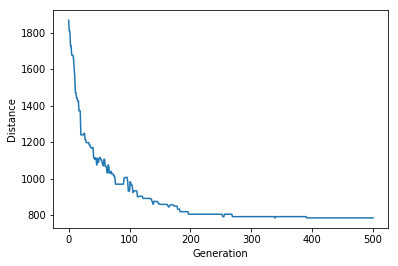

In [18]:
#Просто отново стартираме но този път с новия geneticAlgorithmPlot.
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Използвани ресурси :

https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
https://bg.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D0%BD_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D1%8A%D0%BC
https://en.wikipedia.org/wiki/Travelling_salesman_problem

https://en.wikipedia.org/wiki/Genetic_operator